In [1]:
import os
import subprocess
import firecloud.api as fapi

GEX_Cohort='GEX_CCG1112_LowMt'
REPO = '../..'
WORKFLOW_DATA = f'{REPO}/data/workflow'
RESULT_DATA = f'{REPO}/data/result/cleaned_files'
EXTERNAL_DATA = f'{REPO}/data/external'
Manuscript_RESULT = f'{REPO}/data/result/manuscript_table/'
# load Terra API for get data table from Terra
import sys
import glob
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *
from TerraAPI import get_terra_table_to_df
# load packages and data for the following analysis
import signaturescoring as ssc
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
from statannotations.Annotator import Annotator
import warnings
import commentjson
### Additional Colormap
with open(f'{RESULT_DATA}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

2024-06-07 06:07:20::INFO  pikepdf C++ to Python logger bridge initialized


In [2]:
obs_path = f'{Manuscript_RESULT}/GEX_OBS.csv'
adata = sc.read(f'{WORKFLOW_DATA}/{GEX_Cohort}/gex_qc.h5ad')
obs = pd.read_csv(obs_path,index_col=0)
adata = adata[adata.obs.index.isin(obs.index[obs.Celltype=='CAF']),:]
print(f'{adata.obs.shape[0]:,} CAF cells')
sample_meta = obs.drop_duplicates(subset=['Sample']).copy()
Celltype='CAF'

47,964 CAF cells


# Detect the robust recurrent program robustRPH

- Run the workflow https://app.terra.bio/#workspaces/vanallen-firecloud-nih/HR_BrCa_16-466/workflows/jf_scpipe_rna/GEX_CohortSet_DetectRHP
- Get the basis and coef pickle files.

In [3]:
import pickle
with open(f'{WORKFLOW_DATA}/{GEX_Cohort}/{Celltype}/nmf_basis.pickle', "rb") as input_file:
    programs_basis = pickle.load(input_file)

with open(f'{WORKFLOW_DATA}/{GEX_Cohort}/{Celltype}/nmf_coef.pickle', "rb") as input_file:
    programs_coef = pickle.load(input_file)
    
n_programs = programs_basis[list(programs_basis.keys())[2]].shape[1] * len(programs_basis)
f"Generated {n_programs:,} programs"

'Generated 1,443 programs'

In [4]:
# n_top=50
# if not os.path.isdir(f"{RESULT_DATA}/{Celltype}"):
#     os.makedirs(f"{RESULT_DATA}/{Celltype}")
# robustRPH = sp.ext.getRobustRHP(programs=programs_basis,
#                          n_top=n_top,
#                          intra_min = 35, inter_min = 10,intra_max = 10
#                         )
# with open(f'{RESULT_DATA}/{Celltype}/robustRPH.pickle', 'wb') as handle:
#     pickle.dump(robustRPH, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'{RESULT_DATA}/{Celltype}/robustRPH.pickle', "rb") as input_file:
    robustRPH = pickle.load(input_file)
f"Out of {n_programs:,} detected programs, {robustRPH.shape[1]} programs are robust."

'Out of 1,443 detected programs, 256 programs are robust.'

## Customized clustering on the RPH

### Look at how the n of samples in various timepoints and conditions


In [5]:
sample_stats = pd.crosstab(index=[sample_meta['Treatment_Arm'],sample_meta['Timepoint']],
            columns=sample_meta['BestResponse'])

sample_stats['total'] =sample_stats.sum(axis=1)
sample_stats

BestResponse             0-I  II-III  total
Treatment_Arm Timepoint                    
Chemo->ICI    AfterSurg    1       2      3
              Baseline     1       3      4
              Surg+AC      0       2      2
              W3D1         2       3      5
              W7D1         3       1      4
ICI->Chemo    AfterSurg    0       4      4
              Baseline     2       6      8
              Surg+AC      1       1      2
              W3D1         0       4      4
              W7D1         1       3      4

### Perform the clustering

as shown above, in timepoints Baseline, W3D1, W7D1, and AfterSurg, we have at least `2` samples per timepoints. Thus, we aimed to find metaprograms that at least shared among three samples and set the `Min_group_size` parameter to be `3`.

In [71]:
import palettable
Cluster_Map,MP_Genesets,Programs_Order,MP_colors = sp.ext.clusterRobustRPH(
    robustRPH=robustRPH,
    programs_basis=programs_basis,
    Min_group_size=5,
    Min_intersect_initial = 15,
    Min_intersect_cluster = 10,
    palette=palettable.tableau.Tableau_20.hex_colors + palettable.tableau.TrafficLight_9.hex_colors
)

[Processing]Cluster MP1 has 33 RPH programs.
[Processing]Cluster MP2 has 47 RPH programs.
[Processing]Cluster MP3 has 46 RPH programs.
[Processing]Cluster MP4 has 15 RPH programs.
[Processing]Cluster MP5 has 15 RPH programs.
[Processing]Cluster MP6 has 13 RPH programs.
[Done] Generated 6 MP clusters which covered 66% robust RPH programs.


### Look at MPs related to low data quality 

In [72]:
display(pd.concat([
    MP_Genesets.apply(lambda c:c.str.startswith('MT-').sum(),axis=0).rename('Mitochondrial'),
    MP_Genesets.apply(lambda c:c.str.contains('^RP[LS]').sum(),axis=0).rename('Ribosomal')
],axis=1).sort_values(['Mitochondrial','Ribosomal'],ascending=False))

low_quality_mps = ['MP1']

,Mitochondrial,Ribosomal
MP1,10,29
MP2,0,0
MP3,0,0
MP4,0,0
MP5,0,0
MP6,0,0


### Merge sample metadata into the clustering result

In [73]:
anno = Cluster_Map.rename('MetaProgram').to_frame()
anno['Sample'] = anno.index.map(lambda x: x.split('.')[0])
anno = anno.reset_index().merge(sample_meta,on='Sample',how='left').set_index('index')

### explore the patient specific programs

In [74]:
pt_specific = anno.groupby(['MetaProgram'])['Patient'].nunique().sort_values()
pt_specific = pt_specific[pt_specific ==1].index.tolist()

In [75]:
anno['MetaProgram'].value_counts()[pt_specific]

Series([], Name: MetaProgram, dtype: int64)

In [76]:
anno.loc[anno['MetaProgram'].isin(pt_specific),:]

,MetaProgram,Sample,Sample_Short,Compartment,Lineage,Celltype,Cellstate,Tech,PAM50,absolute_ploidy,...,dist_recur,Stromal TILs,Intratumoral TILs,CPS(%) (Solid Tumors),H-Score,BulkRNA_Profile,WES_Profile,oncotype results,BluePrint,Patient
index,,,,,,,,,,,,,,,,,,,,,


###  Calculate the complexity correaltion

In [77]:
nmf_corr_complexity = []
for k,v in programs_coef.items():
    # only keep cells iwth genes > 1,000
    tmp = v.corrwith(adata.obs.loc[adata.obs.index.isin(v.index),'n_genes_by_counts'])
    nmf_corr_complexity.append(tmp)
del tmp
nmf_corr_complexity=pd.concat(nmf_corr_complexity,axis=0)
dt = pd.concat([nmf_corr_complexity.abs()>.4,Cluster_Map],axis=1,join='inner').groupby(1)[0].mean()
high_complexity = dt[dt>.5].index.tolist()
high_complexity

[]

### Remove patient specific, high complexity, and unknown program

In [78]:
anno = anno.loc[~anno['MetaProgram'].isin(pt_specific+['MP_Unknown']+low_quality_mps+high_complexity),:]
New_Programs_Order = [ x for x in Programs_Order if x in anno.index]
New_MP_Genesets = MP_Genesets[anno['MetaProgram'].unique().tolist()]
f"Generated {anno['MetaProgram'].nunique()} MP clusters which covered {(anno.shape[0]/robustRPH.shape[1]):.0%} robust RPH programs."

'Generated 5 MP clusters which covered 53% robust RPH programs.'

## Visualize the program similarity 

### Visualize the similarity

In [79]:
def jaccard_index(c1,c2):
    c1 = set(c1)
    c2 = set(c2)
    overlap =  c1.intersection(c2)
    union = c1.union(c2)
    value = len(overlap)/len(union)
    return value

## Jaccard index    
sm = robustRPH.apply(
        lambda c1:
            robustRPH.apply(
            lambda c2: jaccard_index(c1,c2) * 100
            ,axis=0)
        ,axis=0)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 32.80972222222222 mm
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


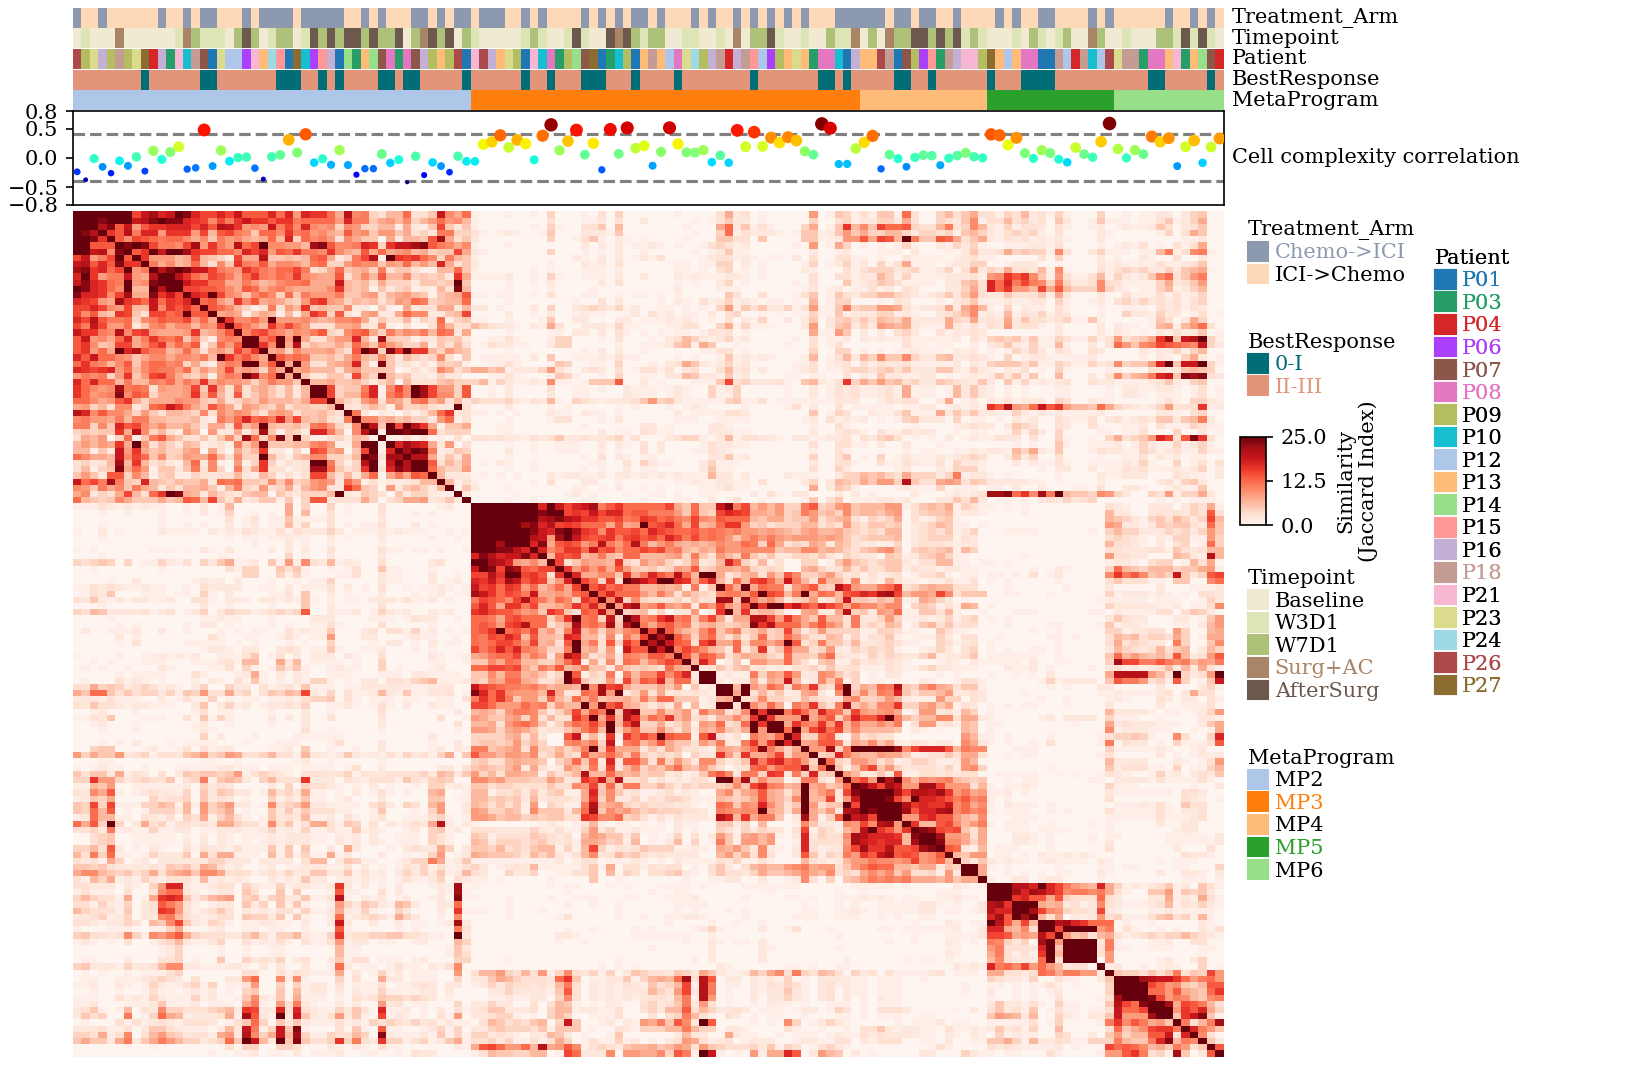

In [80]:
from PyComplexHeatmap import \
ClusterMapPlotter,HeatmapAnnotation,anno_simple,anno_label,DotClustermapPlotter,anno_scatterplot
## Get the order the program
anno['Cell_complexity_cor'] = nmf_corr_complexity
order = New_Programs_Order

## column annotation
n_mp = Cluster_Map.nunique()
COLOR_PAlETTE['MetaProgram'] = MP_colors
col_dict={}
for col in ['Treatment_Arm','Timepoint','Patient','BestResponse','MetaProgram']:
    colors = { k:v for k,v in COLOR_PAlETTE[col].items() if k in anno[col].unique()}
    col_dict[col] = anno_simple(anno[col],
                              legend_kws=dict(frameon=False),
                              colors=colors)
    
col_dict['Cell complexity correlation']= anno_scatterplot(
    anno['Cell_complexity_cor'],height=14,legend=False,grid=False
)

col_ha = HeatmapAnnotation(**col_dict,verbose=0,axis=1)
row_ha = HeatmapAnnotation(
    MetaProgram = anno_simple(anno['MetaProgram'],legend=False),verbose=0,axis=0
)
## plot
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10, 8),dpi=150)


cm = ClusterMapPlotter(data=sm.loc[order,order],
                       top_annotation=col_ha,
                       row_cluster=False,col_cluster=False,
#                        left_annotation=row_ha,
#                        col_split=rph_anno['RPH'],row_split=rph_anno['RPH'],
#                        row_split_gap=0.8,col_split_gap=0.8,
                       vmin=0,
                       vmax=25,
                       label='Similarity\n(Jaccard Index)', row_dendrogram=False,legend_gap=7,
                       cmap='Reds',rasterized=True)

## Change the ylim for the correlation plot
cutoff=.4
ax=col_ha.annotations[5].ax
ax.set_yticks([-0.8,-0.5,0,0.5,0.8]);
ax.axhline(y=cutoff,ls='--',color='gray')
ax.axhline(y=-cutoff,ls='--',color='gray')

## Visualize the gene expression in each MP

In [81]:
def make_index_unique(index: pd.Index, join: str = "-"):
    if index.is_unique:
        return index
    from collections import Counter

    values = index.values.copy()
    indices_dup = index.duplicated(keep="first")
    values_dup = values[indices_dup]
    values_set = set(values)
    counter = Counter()
    issue_interpretation_warning = False
    example_colliding_values = []
    for i, v in enumerate(values_dup):
        while True:
            counter[v] += 1
            tentative_new_name = v + join + str(counter[v])
            if tentative_new_name not in values_set:
                values_set.add(tentative_new_name)
                values_dup[i] = tentative_new_name
                break
            issue_interpretation_warning = True
            if len(example_colliding_values) < 5:
                example_colliding_values.append(tentative_new_name)

    if issue_interpretation_warning:
        warnings.warn(
            f"Suffix used ({join}[0-9]+) to deduplicate index values may make index "
            + "values difficult to interpret. There values with a similar suffixes in "
            + "the index. Consider using a different delimiter by passing "
            + "`join={delimiter}`"
            + "Example key collisions generated by the make_index_unique algorithm: "
            + str(example_colliding_values)
        )
    values[indices_dup] = values_dup
    index = pd.Index(values, name=index.name)
    return index

In [82]:
# ---------------------------------------------------------------------------------------------
# Function for getting a control geneset
# --------------------------------------------------------------------------------------------- 

# - ave_tpm = named vector with the average tpm/cpm expression of genes in the expression matrix
# - program = a character vector of genes in the program 
# - bins = number of bins used to divide ranked genes
# - size = control gene set size scaling factor (e.g. 100x the size of the original program)

# Returns a characther vector with the control gene set 

def control_geneset(ave_tpm, program, bins=50, size=100):
    import random
    # define n bins of gene expression
    expr_bins = pd.cut(ave_tpm,bins)
    # for each program gene, selects 100 control genes from the correspondent bin 
    control_geneset  = {}
    for c in program:
        test = program[c].tolist()
        bin_w_test = expr_bins[test].values
        ctrl_in_bin = expr_bins[expr_bins.isin(bin_w_test)].index.tolist()
        control_geneset[c] = random.choices(ctrl_in_bin,k=size)
    return control_geneset

In [83]:
anno.groupby(['Sample'])['MetaProgram'].unique()

Sample
CCG1112_01_T1_A                       [MP5, MP3]
CCG1112_01_T2_A                  [MP3, MP5, MP2]
CCG1112_01_T3_A                  [MP4, MP2, MP3]
CCG1112_03_T1_A1_SN_5GEX         [MP6, MP2, MP3]
CCG1112_03_T2_A1_SN_5GEX    [MP3, MP2, MP4, MP6]
CCG1112_04_T1_A             [MP5, MP3, MP2, MP6]
CCG1112_06_T4_A                  [MP2, MP3, MP4]
CCG1112_07_T2_A                  [MP3, MP6, MP2]
CCG1112_07_T3_A                       [MP2, MP4]
CCG1112_08_T1_A1_SN_5GEX    [MP3, MP6, MP2, MP5]
CCG1112_08_T2_A1_SN_5GEX    [MP2, MP3, MP6, MP5]
CCG1112_09_T1_A                       [MP3, MP2]
CCG1112_09_T2_A                  [MP2, MP3, MP4]
CCG1112_09_T3_A                  [MP3, MP4, MP2]
CCG1112_10_T2_A                       [MP3, MP2]
CCG1112_10_T4_A                  [MP5, MP3, MP2]
CCG1112_12_T1_A                  [MP3, MP5, MP2]
CCG1112_12_T3_A                  [MP5, MP3, MP2]
CCG1112_13_T1_A1_SN_5GEX    [MP4, MP3, MP2, MP5]
CCG1112_13_T2_A1_SN_5GEX         [MP3, MP5, MP6]
CCG1112_13_T3

## Write out the Genesets for every MP

In [84]:
mp_gmt_path = f'{Manuscript_RESULT}/MPs/CAF/MP_Programs.gmt'
with open(mp_gmt_path,'w') as f:
    for mp in New_MP_Genesets:
        f.write('\t'.join([mp,'MetaProgram_HRpos']+MP_Genesets[mp].tolist())+'\n')

## Define the Geneset for each program

# Annotation of reccurent program

## Gavish et al. 2023 - Hallmarks of transcriptional intratumour heterogeneity across a thousand tumours

In [85]:
ref_ITH = pd.read_excel(f'{EXTERNAL_DATA}/meta_programs_2023-07-13.xlsx',sheet_name='Fibroblasts')
ref_ITH = ref_ITH.loc[:,ref_ITH.columns!='Unassigned']

### Similarity of individual RHP with reference ITH

In [86]:
n_top = min(ref_ITH.shape[0],robustRPH.shape[0])
rph_ref_sm = robustRPH.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: jaccard_index(c1,c2) * 100
            ,axis=0)
        ,axis=0)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 32.80972222222222 mm
Incresing ncol


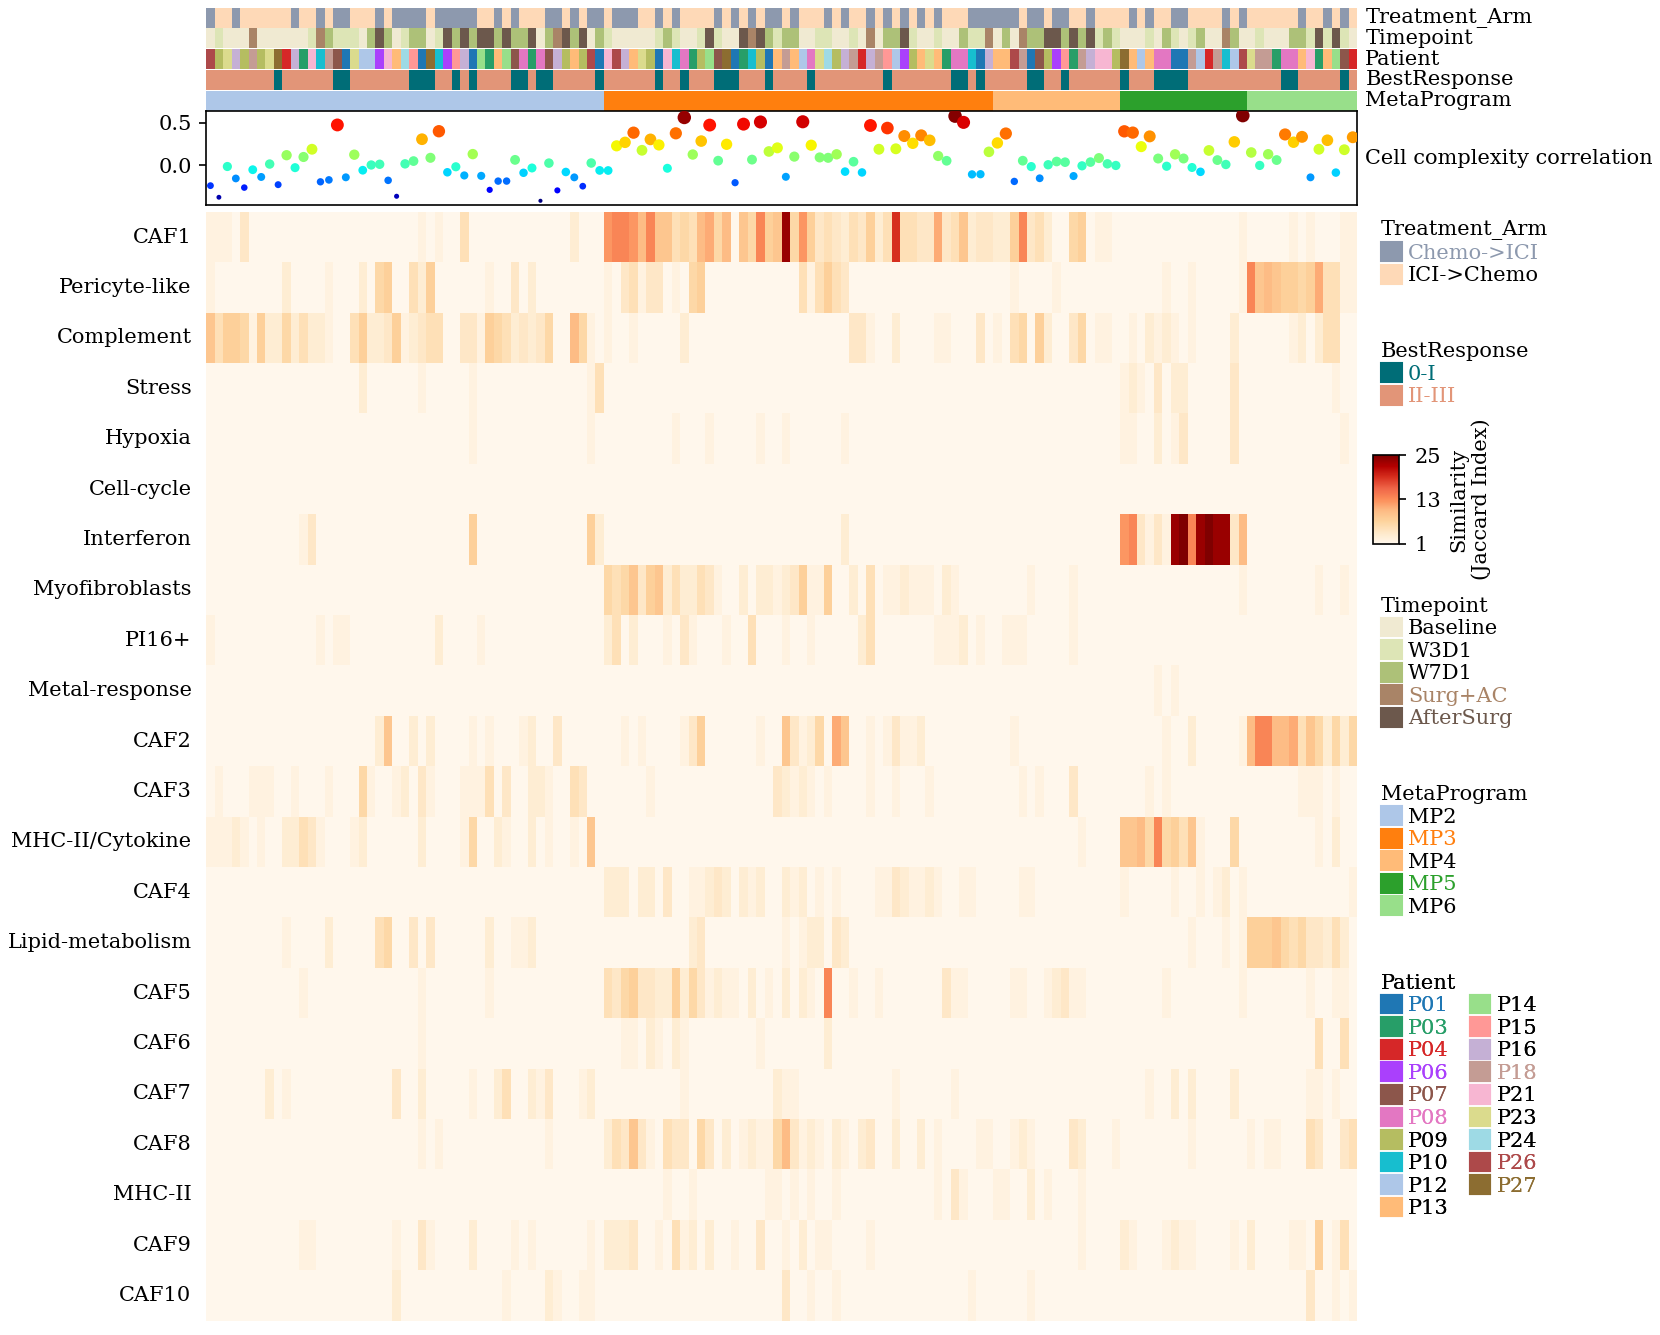

In [87]:
plt.rcParams['font.family'] = 'serif'
plt.figure(figsize=(10, 10),dpi=150)
cm = ClusterMapPlotter(data=rph_ref_sm.loc[:,order],
                       top_annotation=col_ha,
                       left_annotation=None,
                       show_rownames=True,
                       row_names_side='left',
                       row_cluster=False,col_cluster=False,
                       vmin=1,
                       vmax=25,
                       label='Similarity\n(Jaccard Index)', row_dendrogram=False,legend_gap=7,
                       cmap='OrRd',rasterized=True)

### Similarity of metaRHP with reference ITH

In [88]:
(New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0).max().sort_values() > 3)

MP2    True
MP4    True
MP3    True
MP6    True
MP5    True
dtype: bool

<Axes: >

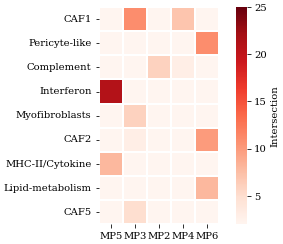

In [89]:
meta_ref_sm = New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0)
meta_ref_sm = meta_ref_sm.loc[((meta_ref_sm >= 5).sum(axis=1)>=1),((meta_ref_sm >= 5).sum(axis=0)>=1)]
sns.heatmap(meta_ref_sm,lw=.2,
              cmap='Reds',vmin=2,vmax=25,square=True,cbar_kws={'label':'Intersection'})

## Hallmark and GO term bp/cc Geneset Enricher 

In [90]:
import gseapy as gp
MP_pathway = {}
for program in New_MP_Genesets:
    genelist = New_MP_Genesets[program].tolist()
    get = True
    while get:
        try:
            enr = gp.enrichr(gene_list=genelist,
                     gene_sets=[f"{EXTERNAL_DATA}/h.all.v2023.1.Hs.symbols.gmt",
                                f"{EXTERNAL_DATA}/c5.go.bp.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c5.go.cc.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c5.go.mf.v2023.1.Hs.symbols.gmt",
                               f"{EXTERNAL_DATA}/c6.all.v2023.1.Hs.symbols.gmt"],# oncogenic
                     organism='human',
                     outdir=None, # don't write to disk
                            )
            get = False
        except Exception as e:
            if e!='Error sending gene list, try again later':
                print(e)
    res = enr.results
#     res = res.loc[res['Adjusted P-value']<0.05,:]
    MP_pathway[program] = res


top_n = 5
enr_res = {}
with pd.ExcelWriter(f'{Manuscript_RESULT}/MPs/CAF/ITH_Enricher.xlsx') as file:
    for name,temp in MP_pathway.items():
        top_geneset = []
        for geneset,df in temp.groupby('Gene_set'):
            top_geneset.append(
                df.sort_values(['Adjusted P-value'],
                                ascending=True).head(top_n)
            )
        result = pd.concat(top_geneset,axis=0)
        result.to_excel(file, sheet_name = name, index=False)
        enr_res[name] = result
del temp,result

In [91]:
enr_res = pd.read_excel(f'{Manuscript_RESULT}/MPs/CAF/ITH_Enricher.xlsx', sheet_name=None)

## Manual annotation

we recorded evidences for the program annotaion in the suppl slides.

In [93]:
New_MP_Genesets.apply(
        lambda c1:
           ref_ITH.apply(
            lambda c2: len(set(c1).intersection(set(c2)))
            ,axis=0)
        ,axis=0).idxmax().sort_index().to_dict()

{'MP2': 'Complement',
 'MP3': 'CAF1',
 'MP4': 'CAF1',
 'MP5': 'Interferon',
 'MP6': 'Pericyte-like'}

In [110]:
enr_res['MP4']

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,c5.go.bp.v2023.1.Hs.symbols.gmt,GOBP_ANIMAL_ORGAN_MORPHOGENESIS,12/412,5.451481e-08,0.000059,13.021552,217.782767,SEMA3C;SFRP4;DHRS3;BMPR1B;TGFBR2;MEIS1;NFIB;EL...
1,c5.go.bp.v2023.1.Hs.symbols.gmt,GOBP_BONE_DEVELOPMENT,7/108,3.966008e-07,0.000214,21.721590,320.183528,LEPR;SFRP4;DHRS3;BMPR1B;TGFBR2;MEIS1;PDGFC
2,c5.go.bp.v2023.1.Hs.symbols.gmt,GOBP_SKELETAL_SYSTEM_DEVELOPMENT,8/201,2.066834e-06,0.000745,13.570390,177.629510,LEPR;SFRP4;DHRS3;BMPR1B;TGFBR2;MEIS1;NFIB;PDGFC
3,c5.go.bp.v2023.1.Hs.symbols.gmt,GOBP_TUBE_DEVELOPMENT,10/474,2.327256e-05,0.006289,7.665044,81.772496,LEPR;SEMA3C;PTGIS;TGFBR2;MEIS1;NFIB;ESR1;MYLK;...
4,c5.go.bp.v2023.1.Hs.symbols.gmt,GOBP_OUTFLOW_TRACT_MORPHOGENESIS,4/45,5.106464e-05,0.009200,26.783133,264.682120,TGFBR2;SEMA3C;DHRS3;ELN
5,c5.go.cc.v2023.1.Hs.symbols.gmt,GOCC_ELASTIC_FIBER,2/4,1.303900e-04,0.011605,223.666667,2000.693948,FBLN1;ELN
6,c5.go.cc.v2023.1.Hs.symbols.gmt,GOCC_CILIARY_MEMBRANE,2/12,1.401491e-03,0.041578,53.156288,349.248451,PKD2;DHRS3
7,c5.go.cc.v2023.1.Hs.symbols.gmt,GOCC_CAVEOLA,3/47,1.341730e-03,0.041578,18.364106,121.456436,TGFBR2;KCNMA1;PTGIS
8,c5.go.cc.v2023.1.Hs.symbols.gmt,GOCC_PLASMA_MEMBRANE_REGION,7/433,2.969216e-03,0.052852,4.775235,27.789280,LEPR;KCNMA1;DHRS3;PTGIS;TGFBR2;MYLK;PKD2
9,c5.go.cc.v2023.1.Hs.symbols.gmt,GOCC_PLASMA_MEMBRANE_RAFT,3/59,2.592339e-03,0.052852,14.423583,85.895245,TGFBR2;KCNMA1;PTGIS


## Final MP annotation

In [101]:
MP_anno_map = {
 'MP2': 'EMT_Bile_acid',
 'MP3': 'EMT_Adhesion',
 'MP4': 'EMT_Tube_dev',
 'MP5': 'Interferon',
 'MP6': 'EMT_Notch'
}

## Assign the annotation to MPs column

In [102]:
anno['MPs'] = anno.MetaProgram.map(MP_anno_map)
anno['MPs'].value_counts().sort_index()

EMT_Adhesion     46
EMT_Bile_acid    47
EMT_Notch        13
EMT_Tube_dev     15
Interferon       15
Name: MPs, dtype: int64

In [111]:
MP_Visual_Genes = {
 'MP2': ['LAMA2','SLIT2','SLIT3'],
 'MP3': ['TIMP3','ACTA2','POSTN'],
 'MP4': ['SFRP4','TGFBR2','FBLN1'],
 'MP5': ['MX1','CXCL10','IFIH1'],
 'MP6': ['PDGFRB','NOTCH3','JAG1']
}

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


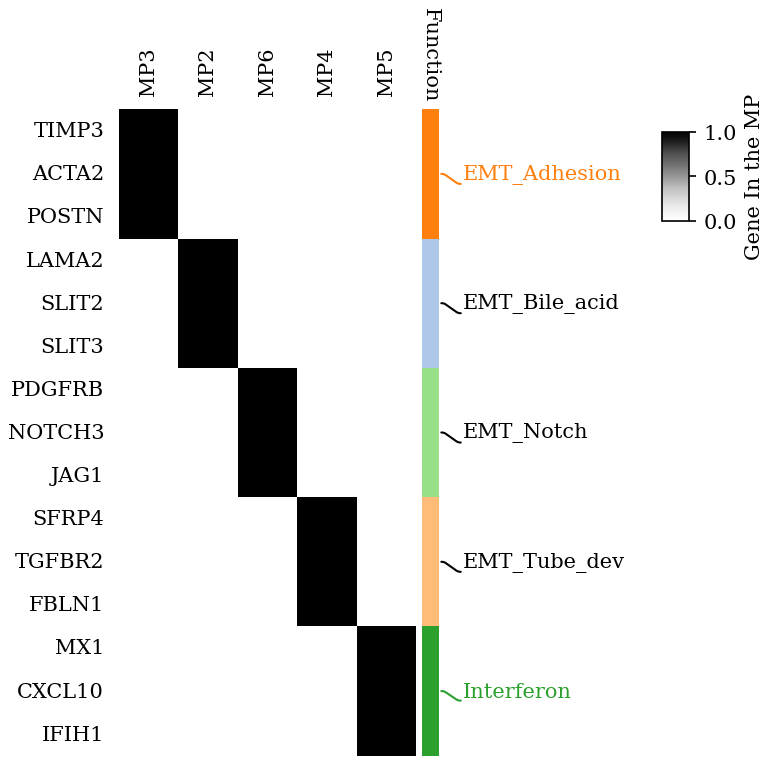

In [112]:
genes = pd.Series(np.vstack(MP_Visual_Genes.values()).flatten())
genes.index=genes
dt = New_MP_Genesets.apply(lambda c: genes.map(lambda x: x in c.values),axis=0).astype(int)
dt = dt.sort_values(dt.columns.tolist())

df_rows = pd.DataFrame(MP_Visual_Genes).unstack().reset_index().set_index(0)
colors = { MP_anno_map[k]:v for k,v in COLOR_PAlETTE['MetaProgram'].items() if k in df_rows['level_0'].unique()}
df_rows['MP'] = df_rows['level_0'].map(MP_anno_map)
df_rows = df_rows.sort_values('MP')
col_orders = df_rows['level_0'].unique().tolist()
dt = dt[col_orders].sort_values(col_orders,ascending=False)
df_rows = df_rows.loc[dt.index,:]

row_ha = HeatmapAnnotation(
    Function=anno_simple(df_rows['MP'],legend=False,
                           legend_kws=dict(frameon=False),
                           colors=colors),
     Anno=anno_label(df_rows['MP'],legend=False,
                          colors=colors,merge=True),
    verbose=0,axis=0,plot_legend=True)


plt.figure(figsize=(3, 5),dpi=150)
cm = ClusterMapPlotter(data=dt,
                       right_annotation=row_ha,
                       col_cluster=False,
                       row_cluster=False,
                       show_colnames=True,
                       show_rownames=True,
                       vmax=1,
                       vmin=0,
                       label='Gene In the MP',
                       cmap='Greys',rasterized=True,col_names_side='top')
# plt.suptitle('Metaprogram related function')

## Store the annotation

In [114]:
mp_anno_path = f'{Manuscript_RESULT}/MPs/CAF/MetaProgram_Annotation.csv'
anno.to_csv(mp_anno_path,index=True)

# Cellstate annotation

In [115]:
scores_path = f'{Manuscript_RESULT}/MPs/CAF/MetaProgram_score.csv'
ref_ITH=pd.read_table(mp_gmt_path,header=None,index_col=0).drop([1],axis=1).T
ref_anno = pd.read_csv(mp_anno_path)
MP_anno_map = ref_anno[['MetaProgram','MPs']].drop_duplicates().set_index('MetaProgram')['MPs'].to_dict()
# get MP sores on all cells 
scores = pd.read_csv(scores_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
scores = scores[scores.columns[scores.columns.str.endswith(signature_method)]]
scores.columns = scores.columns.map(lambda x:x.split('_')[0]).map(MP_anno_map)
scores

,Interferon,EMT_Adhesion,EMT_Bile_acid,EMT_Tube_dev,EMT_Notch
TCTCAATTCAATCTAG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.070907,2.430149,4.846743,2.557661,1.202694
GGTCTTTGTAATAACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.096463,2.018342,5.662187,2.488893,1.199476
CATTATCTCGTTCACC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.878099,2.728160,4.082625,2.658013,1.323533
AATATCCCAGGACCTT-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.630541,2.450564,2.787448,3.420940,1.438639
TGAACAACACCTAATG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.326327,2.219418,5.486287,2.527283,1.371208
...,...,...,...,...,...
TTTACTGGTATCAGTC-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.645439,1.396184,1.142171,1.738064,0.686743
CCAATCCGTTCGCTAA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.268572,0.268572,2.377088,0.577327,-0.102381
TTCTCAAGTCTAGTCA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.262333,0.749258,1.687988,0.485626,-0.103575
GTACTCCCACGAGAGT-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.115331,0.294639,1.320460,1.564409,0.433413


In [116]:
from signaturescoring.scoring_methods.gmm_postprocessing import GMMPostprocessor
import anndata
caf = anndata.AnnData(obs=scores)
# initialize GMMPostprocessor
gmm_post = GMMPostprocessor(
    n_components=scores.shape[1]
)
# fit the GMM model on the 3 columns of the scores
features_name = scores.columns.tolist()
store_name_pred, store_names_proba, _ = gmm_post.fit_and_predict(caf,features_name )

# assign clusters to signatures
assignments = gmm_post.assign_clusters_to_signatures(caf,features_name, store_names_proba, plot=False)
scoring_names_gmm = []
for key, val in assignments.items():
    if key =='rest':
        continue
    caf.obs[key+'_gmm'] = caf.obs[val].copy()
    scoring_names_gmm.append(key+'_gmm')

In [121]:
assignments

{'Interferon': '0_GMM_proba',
 'EMT_Adhesion': '3_GMM_proba',
 'EMT_Bile_acid': '1_GMM_proba',
 'EMT_Tube_dev': '2_GMM_proba',
 'EMT_Notch': '4_GMM_proba'}

In [125]:
curr_val= caf.obs[scoring_names_gmm].idxmax(axis="columns")
cellstate= curr_val.map(lambda x:'CAF.'+x.replace('_gmm','')).rename('Cellstate').to_frame()
cellstate.to_csv(f'{Manuscript_RESULT}/MPs/CAF/Annotation.csv')

In [126]:
# cross sanity check
for c in ['Cellstate','BestResponse','Patient','Timepoint','Sample_Short','Treatment_Arm','RCB']:
    adata.obs[c] = obs.loc[adata.obs.index,c]
pd.crosstab(adata.obs.loc[cellstate.index,'Cellstate'],cellstate['Cellstate'])

Cellstate,CAF.EMT_Adhesion,CAF.EMT_Bile_acid,CAF.EMT_Notch,CAF.EMT_Tube_dev,CAF.Interferon
Cellstate,,,,,
CAF,11461,14833,6523,8648,6499


## Canonical marker visualization

In [127]:
adata.obs.loc[cellstate.index,'Cellstate'] = cellstate['Cellstate']

In [41]:
sp.utils.log1pNorm(adata)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 30.516666666666666 mm


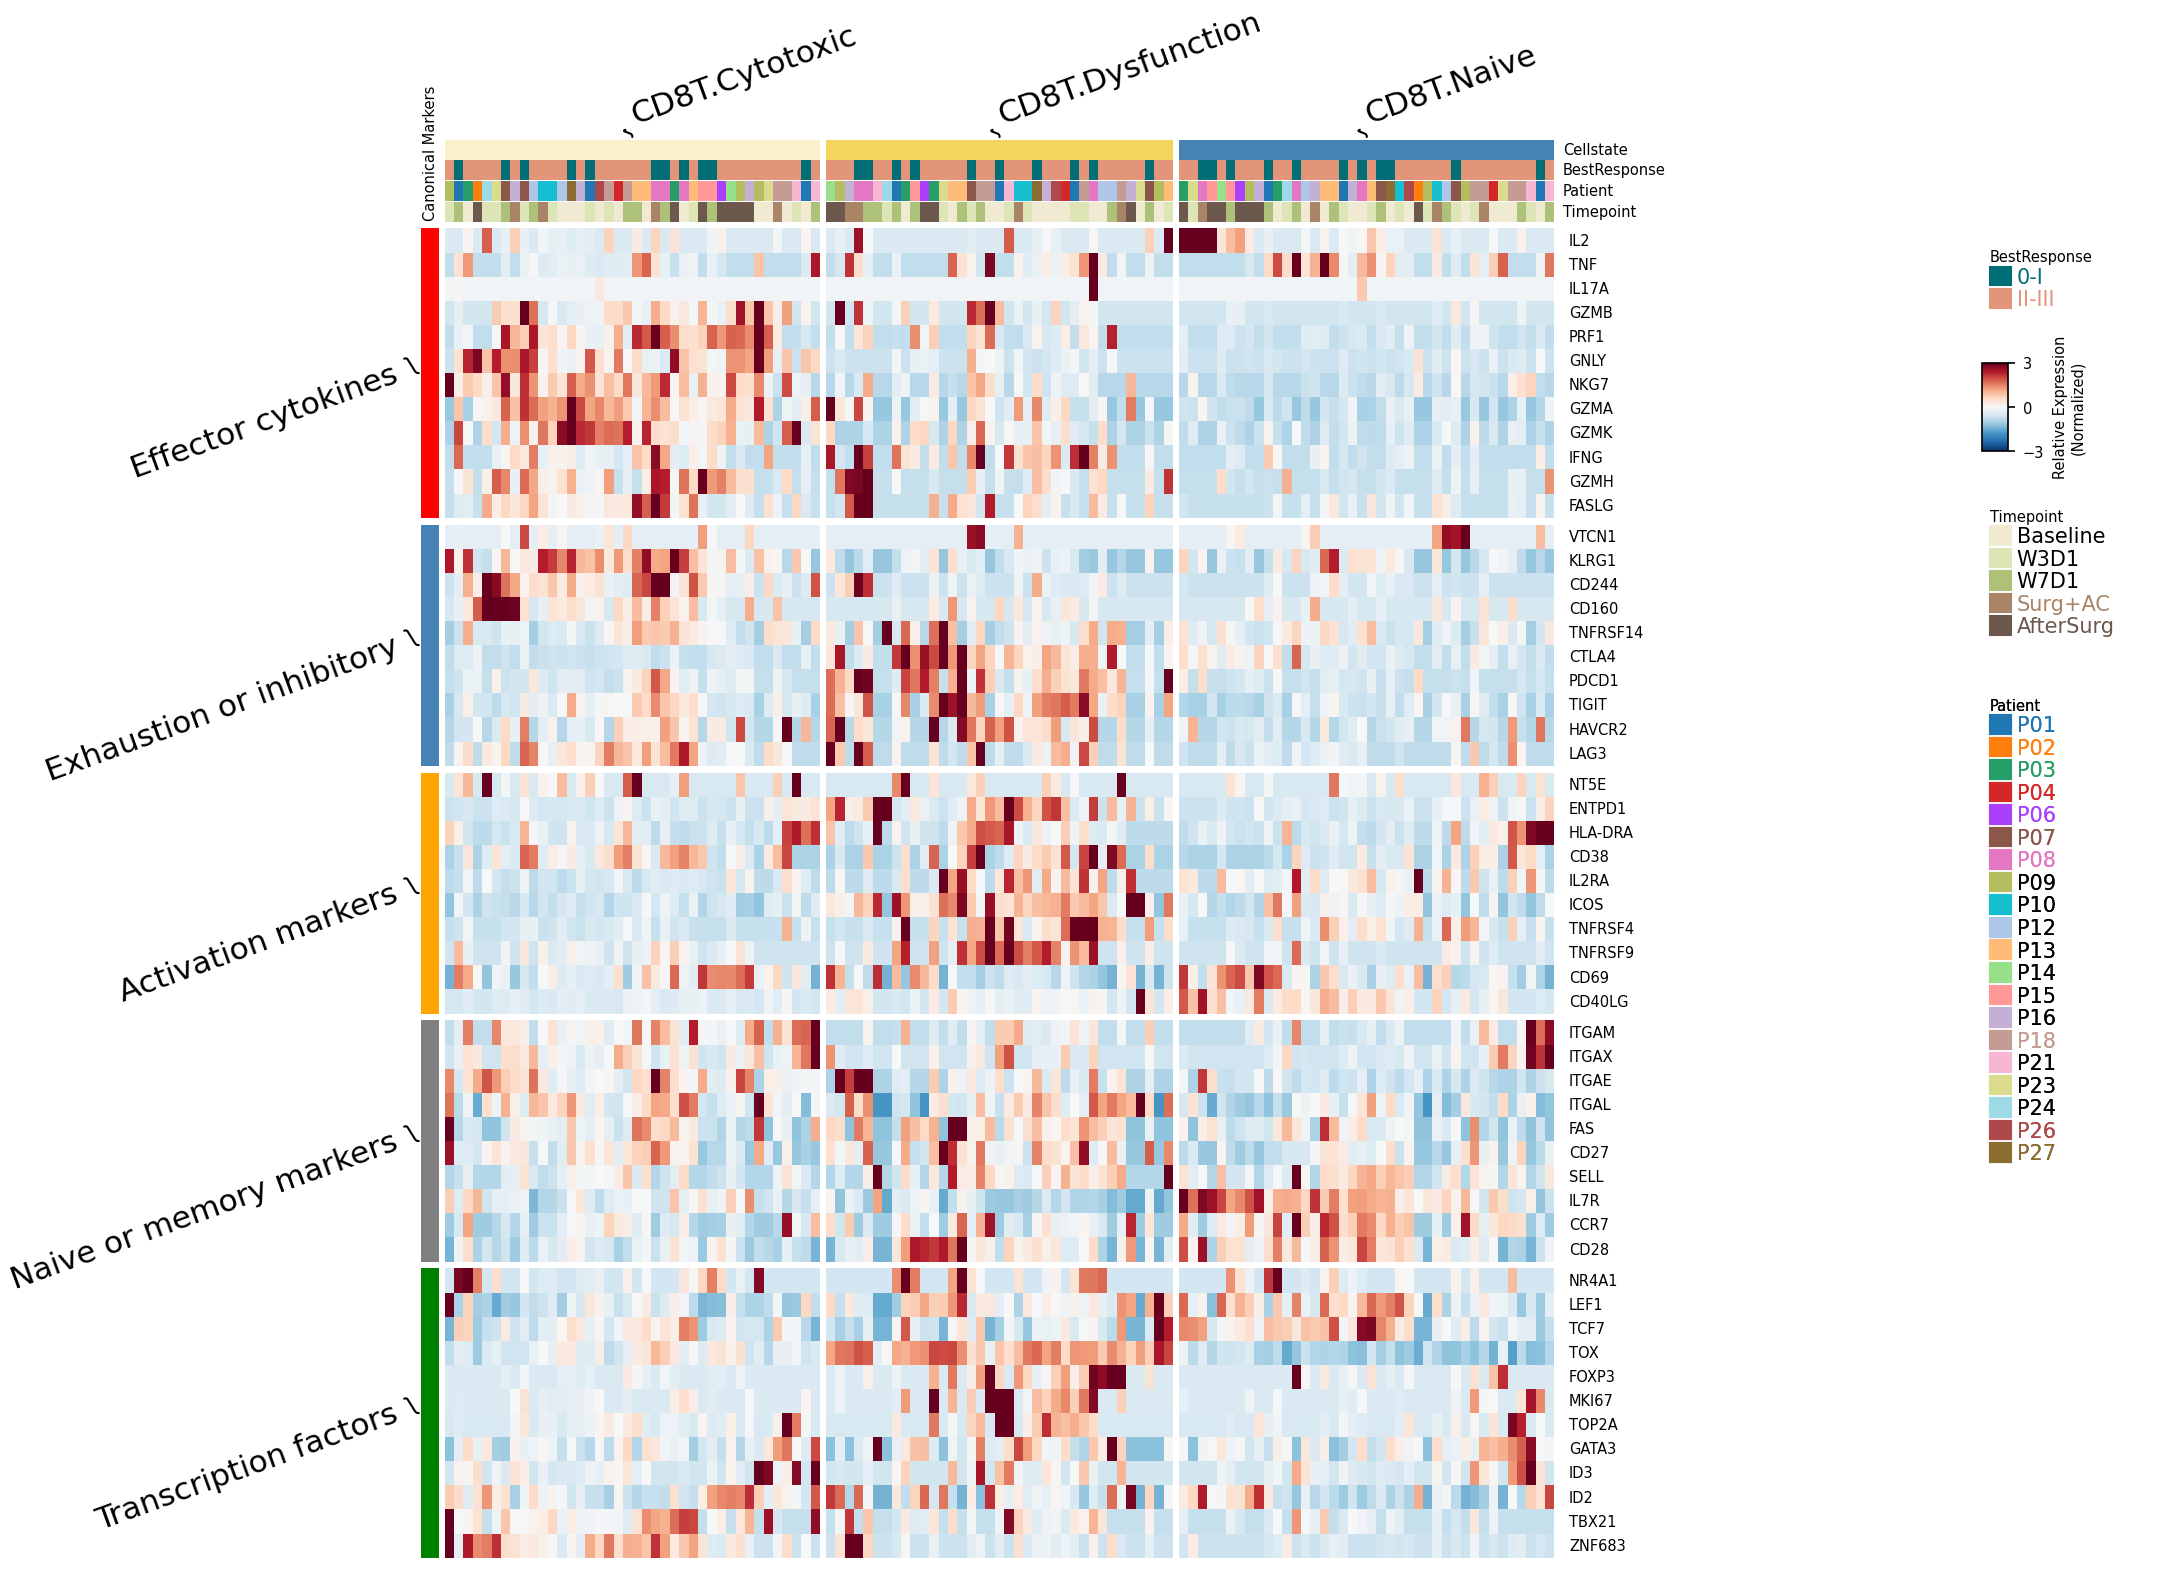

In [46]:
cd8T_custom_markers = {
    'Naive or memory markers':['CCR7','SELL','IL7R','CD28','FAS','CD27','ITGAE','ITGAL','ITGAM','ITGAX'],
    'Exhaustion or inhibitory':['PDCD1','TIGIT','HAVCR2','LAG3','CTLA4','VTCN1','CD244','KLRG1','TNFRSF14','CD160'], #'BLTA'
    'Activation markers':['CD38','ENTPD1','NT5E','CD69','IL2RA','ICOS','TNFRSF4','TNFRSF9','HLA-DRA','CD40LG'],
    'Effector cytokines':['GZMA','GZMB','GZMH','GZMK','PRF1','NKG7','GNLY','IFNG','FASLG','TNF','IL17A','IL2'],
    'Transcription factors':['LEF1','TCF7','TBX21','TOX','GATA3','ID2','ID3','NR4A1','ZNF683','FOXP3','MKI67','TOP2A'],#'EMOES','PRMD1'
}
marker_df = []
for k,v_list in cd8T_custom_markers.items():
    for v in v_list:
        marker_df.append(
            pd.Series({v:k},name='Canonical Markers')
        )
    
marker_df = pd.concat(marker_df).to_frame()
COLOR_PAlETTE['Canonical Markers']={
    'Naive or memory markers':'gray',
    'Exhaustion or inhibitory':'steelblue', 
    'Activation markers':'orange',
    'Effector cytokines':'red',
    'Transcription factors':'green',
    'NK/gamma-delta T cell genes':'salmon'
}
aggregate_heatmap(adata=adata,
                  features=marker_df,
                  top_anno_columns=['Cellstate','BestResponse','Patient','Timepoint'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Canonical Markers',
                  row_split_gap=1,
                  palette=COLOR_PAlETTE,
                  figsize=(10,11),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Relative Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )